In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from matplotlib.pyplot import figure
from scipy.sparse import csr_matrix
from sklearn import preprocessing
from numpy import count_nonzero
import matplotlib.pyplot as plt
from numpy import linalg as LA
import collections, numpy
from numpy import array
from time import time
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.io
import datetime
import random
import math

In [2]:
train = pd.read_csv("C:\\Users\\Hunor\\Documents\\Moj Master rad\\IoT\\training.csv")
test = pd.read_csv("C:\\Users\\Hunor\\Documents\\Moj Master rad\\IoT\\test.csv")
anomalies = open("C:\\Users\\Hunor\\Documents\\Moj Master rad\\IoT\\anomaliestxt.txt", "r")

string = anomalies.readlines()
mylist = []
for x in string:
    mylist.append(x.replace("\n", ""))
    
#we have 166 anomaly detected (encoded by 1)
test_labels = np.zeros(test.shape[0])
for i in range(test.shape[0]): #1571
    if mylist.count(test.timestamp[i]) == 1:
        test_labels[i]=1
    else:
        test_labels[i]=-1
        
#without location 4:
#with location 1:
train = train.iloc[:,4:] #droping out the first column
test = test.iloc[:,4:] #droping out the first column

np.random.seed(11)
x0 = np.random.uniform(0,1,train.shape[1]+1)

# Preprocessing MinMaxScaler

In [3]:
#scaler = preprocessing.MinMaxScaler()
#names = train.columns
#d = scaler.fit_transform(train)
#train = pd.DataFrame(d, columns=names)
#names = test.columns
#t = scaler.fit_transform(test)
#test = pd.DataFrame(t, columns=names)

# Preprocessing StandardScaler

In [4]:
scaler = preprocessing.StandardScaler()
names = train.columns
d = scaler.fit_transform(train)
train = pd.DataFrame(d, columns=names)
names = test.columns
t = scaler.fit_transform(test)
test = pd.DataFrame(t, columns=names)

In [5]:
def aimh(N_k):
    return (N_max-N_k)/N_max

In [6]:
def hinge_loss(y, N): 
    x = y[:-1]
    r = y[-1]
    prediction = train.iloc[:N,:].dot(x)
    maximums = np.maximum(0,r-prediction)
    return (l*LA.norm(x,2)**2)/2-(l*r)+(np.sum(maximums)/N)

In [7]:
def hl_der(y, N):
    ro=y[-1]
    x=y[:-1]
    y=train.iloc[:N,:].dot(x)
    maximums=ro-y
    all_der=train.iloc[:N,:]
    greater_der=all_der[maximums>0]
    zero_der=all_der[maximums==0]
    beta=np.random.uniform(0,1,np.size(zero_der))
    if len(zero_der)!=0:
        new_x = l*x-greater_der.sum()/(N)-np.dot(zero_der,beta)/(N)
        new_r = np.array([sum(beta)/(N)+len(greater_der)/(N)-l])
        return np.concatenate(new_x,new_r)
    elif len(zero_der)==0:
        return np.concatenate((l*x-greater_der.sum()/N,np.array([len(greater_der)/(N)-l])))

In [8]:
def new_sample(N_k): #DONE1
    return math.ceil(N_max*(1-r*aimh(N_k)))

In [9]:
def merit_function(x_k, N_k, theta_k): #DONE1
    return theta_k*hinge_loss(x_k, N_k)+(1-theta_k)*aimh(N_k)

In [10]:
def find_theta(x, N_tilda, N, theta): #DONE1
    sum1 = merit_function(x, N_tilda, theta)-merit_function(x, N, theta)
    sum2 = (1-r)/2*(aimh(N_tilda)-aimh(N))
    if sum1 <= sum2:
        #print("Theta - Same")
        return theta
    else:
        sum3 = (1+r)*(aimh(N)-aimh(N_tilda))
        sum4 = hinge_loss(x, N_tilda)-hinge_loss(x, N)+aimh(N)-aimh(N_tilda)
        #print("Theta - Upgrade")
        return sum3/(2*sum4)

In [11]:
def model_Y(y, p, N, B): #DONE1
    return np.matmul(np.matmul(p,np.linalg.inv(B)),p)/2 + sup_gp(y, p, N)

In [12]:
def sup_gp_old(y, p, N): #SLOW VERSION 100% Accurate
    x = y[:-1]
    r = y[-1]
    px = p[:-1]
    pr = p[-1]
    
    sum1 = 0
    sum2 = 0
    sum3 = 0
    for i in range(N):
        decision1 = r-np.matmul(x, train.iloc[i,:])
        quantity = np.matmul(px,train.iloc[i,:])
        if decision1 > 0:
            sum1 += quantity
            sum2 += 1
        if decision1 == 0:
            decision2 = pr - quantity
            if decision2 > 0:
                sum3 += decision2    
    return l*np.matmul(px,x)-sum1/N-l*pr+(pr*sum2)/N+sum3/N

In [13]:
def sup_gp(y, p, N): #FASTER CODE 99% sure accurate
    x = y[:-1]
    r = y[-1]
    px = p[:-1]
    pr = p[-1]
    
    y=train.iloc[:N,:].dot(x)
    decision = r - y
    all_der = train.iloc[:N,:]
    greater_der = all_der[decision>0]
    zero_der = all_der[decision==0]
    h = zero_der.dot(px)
    h1 = pr - h
    check = zero_der[h1>0]
    a = l*(px.dot(x))
    b = (greater_der.dot(px)).sum()
    c = l*pr
    d = pr*len(greater_der)
    e = pr-check.dot(px)
    if len(e)==0:
        return a-b/N-c+d/N
    else:
        return a-b/N-c+d/N+e/N

In [14]:
def argsup_gp(y, p, N): #DONE1
    x = y[:-1]
    r = y[-1]
    px = p[:-1]
    pr = p[-1]
    
    sum1 = 0
    sum2 = 0
    sum3 = np.zeros(x.shape[0])
    sum4 = np.zeros(x.shape[0])
    for i in range(N):
        decision1 = r - np.matmul(x,train.iloc[i,:])
        if decision1 > 0:
            sum1 += 1
            sum3 += train.iloc[i,:]
        if decision1 == 0:
            if pr-np.matmul(px,train.iloc[i,:]) > 0:
                sum2 += 1
                sum4 += train.iloc[i,:]
    new_x = np.array(l*x-sum3/N-sum4/N)
    new_r = -l+sum1/N+sum2/N
    return np.concatenate((new_x, new_r), axis=None)

In [15]:
def descentDirection(g0_tilda, e, i_max, B, x, N): #DONE1
    G_tilda = []
    G_bar = []
    P = []
    E = []
    
    #Step 0
    g0_bar = g0_tilda
    G_bar.append(g0_bar)
    G_tilda.append(g0_tilda)
    P.append(np.matmul(-B, G_tilda[0]))
    
    #Step 1
    G_tilda.append(argsup_gp(x, P[0], N))
        
    #Step 2
    E.append(np.matmul(P[0],G_tilda[1])-np.matmul(P[0],G_bar[0]))
    
    #Step 3
    i = 0
    while (np.matmul(G_tilda[i+1],P[i])>0 or E[0]>e) and E[i]>0 and i<i_max:
        first = np.matmul(G_bar[i]-G_tilda[i+1],np.matmul(B,G_bar[i]))
        second = np.matmul(G_bar[i]-G_tilda[i+1],np.matmul(B,G_bar[i]-G_tilda[i+1]))
        ni = min(1,first/second)
        G_bar.append((1-ni)*G_bar[i]+ni*G_tilda[i+1])
        P.append((1-ni)*P[i]-ni*np.matmul(B,G_tilda[i+1]))
        G_tilda.append(argsup_gp(x, P[i+1], N))
        e_list = []
        j = 0
        while j <= i+1:
            sum1 = np.matmul(P[j],G_tilda[j+1])
            sum2 = np.matmul(P[j],G_bar[j])+np.matmul(P[i+1],G_bar[i+1])
            e_list.append(sum1-sum2/2)
            j += 1
        E.append(min(e_list))
        i += 1
        
    #Step 4
    list_p = []
    j = 0
    while j <= i:
        list_p.append(model_Y(x, P[j], N, B))
        j += 1
    p_final = P[np.argmin(list_p)]
    
    #STEP5
    if sup_gp(x, p_final, N) < 0:
        #print("Iteration in finding P is %s" %i)
        return p_final
    else:
        print("!!! FAILED TO FIND DESCENT DIRECTION!!!")

In [16]:
def check1(x, alpha, p, N_trial, N_tilda): #DONE1
    sum1 = hinge_loss(x+alpha*p, N_trial)
    sum2 = hinge_loss(x, N_tilda)
    sum3 = -gama*alpha*(LA.norm(p,2)**2)
    return (sum1-sum2)<=sum3

In [17]:
def check2(N_trial, N_tilda, alpha, p): #DONE1
    sum1 = aimh(N_trial)
    sum2 = aimh(N_tilda)
    sum3 = gama_k*alpha*alpha*(LA.norm(p,2)**2)
    return sum1<=(sum2+sum3)

In [18]:
def check3(x, alpha, p, N_trial, theta, N_start, N_tilda): #DONE1
    sum1 = merit_function(x+alpha*p, N_trial, theta)
    sum2 = merit_function(x, N_start, theta)
    sum3 = (1-r)*(aimh(N_tilda)-aimh(N_start))/2
    return (sum1-sum2)<=sum3

In [19]:
def BFGS(B, g_new, g_old, x_new, x_old): #DONE1
    I = np.identity(g_new.size)
    y = g_new-g_old
    s = x_new-x_old
    sT = np.reshape(s,(1,-1)) # Dimension: 1xN
    s = np.reshape(s,(-1,1)) # Dimension: Nx1
    yT = np.reshape(y,(1,-1))
    y = np.reshape(y,(-1,1))
    ro = 1/(yT@s)
    sum1 = I-ro*(s@yT)
    sum2 = I-ro*(y@sT)
    sum3 = ro*(s@sT)
    return (np.matmul(np.matmul(sum1,B),sum2)+sum3)

In [20]:
def theta_k(theta): #DONE1
    return N_max*theta/(1-theta)

In [21]:
def p_N_trial(N_start, N_tilda, theta, theta_k, alpha, p ,x): #DONE1
    sum1 = N_start + ((1-r)/2)*(N_tilda-N_start)/(1-theta)
    sum2 = theta_k*(gama*alpha*(LA.norm(p,2)**2) - hinge_loss(x, N_tilda) + hinge_loss(x, N_start))
    return round(math.floor(sum1-sum2))
    #return sum1, sum2

In [22]:
def first_N_trial(N_start, N_tilda, theta, theta_k, alpha, x): #DONE1
    sum1 = N_start+(1-r)/2*(N_tilda-N_start)/(1-theta)
    sum2 = theta_k*(gama*alpha-hinge_loss(x, N_tilda)+hinge_loss(x, N_start))
    return math.ceil(sum1-sum2)

In [23]:
def candidates(N_trial, N_tilda): #DONE1
    storage = []
    storage.append(int(N_trial))
    storage.append(int(math.ceil((N_trial+N_tilda)/2)))
    storage.append(N_tilda)
    return storage

In [24]:
def pred_labels(y):
    x = y[:-1]
    r = y[-1]
    pred_labels = np.zeros(test.shape[0])
    for i in range(test.shape[0]):
        if abs(np.matmul(x,test.iloc[i,:])) <= abs(r):
            pred_labels[i]=1
        else:
            pred_labels[i]=-1
    return pred_labels

In [25]:
def scores(pred, printing):
    TN, FP, FN, TP = confusion_matrix(test_labels, pred).ravel()
    P = precision_score(test_labels, pred)
    R = recall_score(test_labels, pred)
    F1 = f1_score(test_labels, pred)
    A = accuracy_score(test_labels, pred)
    if printing == "True":
        print("TP: %s | FP: %s | FN: %s | TN: %s" %(TP,FP,FN,TN))
        print("Precision: %s | Recall: %s | Accuracy: %s | F1 score: %s " %(round(P,3),round(R,3),round(A,3),round(F1,3)))
    return F1, A, P, R, TP, TN

In [26]:
def backtracking_IRNS(B, x, N_trial, N_tilda, N_start, theta):
    alpha_start = 0.5
    degree = 0
    g0 = hl_der(x, N_trial[0])
    g1 = hl_der(x, N_trial[1])
    g2 = hl_der(x, N_trial[2])
    
    p0 = descentDirection(g0, e, i_max, B, x, N_trial[0])
    #print("P0 done")
    p1 = descentDirection(g1, e, i_max, B, x, N_trial[1])
    #print("P1 done")
    p2 = descentDirection(g2, e, i_max, B, x, N_trial[2])
    #print("P2 done")
    
    while True:
        alpha = alpha_start**degree
        
        first = check1(x, alpha, p0, N_trial[0], N_tilda)
        second = check2(N_trial[0], N_tilda, alpha, p0)
        third = check3(x, alpha, p0, N_trial[0], theta, N_start, N_tilda)
        if first and second and third:
            #print("Alpha: %s | Trial value: %s" %(alpha,0))
            return alpha, p0, N_trial[0]
            break
        else:
            first = check1(x, alpha, p1, N_trial[1], N_tilda)
            second = check2(N_trial[1], N_tilda, alpha, p1) 
            third = check3(x, alpha, p1, N_trial[1], theta, N_start, N_tilda)
            if first and second and third:
                #print("Alpha: %s | Trial value: %s" %(alpha,1))
                return alpha, p1, N_trial[1]
                break
            else:
                first = check1(x, alpha, p2, N_trial[2], N_tilda)
                second = check2(N_trial[2], N_tilda, alpha, p2) 
                third = check3(x, alpha, p2, N_trial[2], theta, N_start, N_tilda)
                if first and second and third:
                    #print("Alpha: %s | Trial value: %s" %(alpha,2))
                    return alpha, p2, N_trial[2]
                    break
                else:
                    if degree >= 10:
                        #print("forced to stop")
                        return alpha, p2, N_trial[2]
                        break
                    degree += 1
                    #print(degree)

In [27]:
def backtracking_normal(B, x, N_trial, N_tilda, N_start, theta):
    alpha_start = 0.5
    degree = 0
    g = hl_der(x, N_trial)
    p = descentDirection(g,e,i_max,B,x,N_trial)
    while True:
        alpha = alpha_start**degree
        
        first = check1(x, alpha, p, N_trial, N_tilda)
        third = check3(x, alpha, p, N_trial, theta, N_start, N_tilda)
        #print(first, third)
        if first and third:
            #print("Alpha: %s" %alpha)
            return alpha, p
            break
        else:
            if degree >= 10:
                #print("forced to stop")
                return alpha, p
                break
            degree += 1
            #print(degree)

In [28]:
N_max = train.shape[0]
B0 = np.identity(x0.size)
gama = math.pow(10,-4)
e = math.pow(10,-4)
m = math.pow(10,-4)
theta0 = 0.8
i_max = 100
gama_k = 1
r = 0.95
l = 0.05 #PAMETER

In [29]:
def algorithm(method): 
    start = time()
    
    best_score = np.inf
    max_fev = 0
    MAX_FEV = []
    MAX_FEV.append(max_fev)
    
    f_Ntrain = []
    N_tilda = []
    trial_N = []
    ITER = []
    ACC = []
    F1 = []
    T = []
    X = []
    P = []
    B = []
    G = []
    C = []
    A = []
    N = []
    PREC=[]
    REC=[]
    
    X.append(x0)
    if method == "IRNS":
        N0 = math.ceil(0.1*N_max)
        N.append(N0)
        g0 = hl_der(x0, N[0])
        G.append(g0)
        max_fev += N[0]
        MAX_FEV.append(max_fev)
        f_Ntrain.append(hinge_loss(X[0],N_max))
         
    if method == "HEUR":
        N0 = math.ceil(0.1*N_max)
        N.append(N0)
        g0 = hl_der(x0, N[0])
        G.append(g0)
        max_fev += N[0]
        MAX_FEV.append(max_fev)
        f_Ntrain.append(hinge_loss(X[0],N_max))
        
    if method == "FSS":
        N0 = train.shape[0]
        N.append(N0)
        g0 = hl_der(X[0], N[0])
        G.append(g0)
        max_fev += N[0]
        MAX_FEV.append(max_fev)
        f_Ntrain.append(hinge_loss(X[0],N_max))
        
    N_tilda.append(0)
    T.append(theta0)
    B.append(B0)

    F, Accuracy, Precision, Recall, TP, TN = scores(pred_labels(x0),"True")
    F1.append(F)
    f1max = F1[0]
    #print("R = %s" %X[-1][-1])
    k = 0
    ITER.append(0)
    #while max_fev <= 10**5:
    while k<=200:
        if method == "IRNS":
            N_tilda.append(new_sample(N[k]))
            T.append(find_theta(X[k], N_tilda[k+1], N[k], T[k]))
            
            #N_trial = round(0.8*N_tilda[-1])
            if k == 0:
                N_trial = first_N_trial(N[0], N_tilda[1], T[1], theta_k(T[1]), 1, X[0])
            else:
                N_trial = p_N_trial(N[k], N_tilda[k+1], T[k+1], theta_k(T[k+1]), A[-1], P[k-1] ,X[k])
            
            trial_N.append(N_trial)
            three_canditates = candidates(N_trial, N_tilda[k+1])
            C.append(three_canditates)
            #print(C[k])
            alpha, p, N_new = backtracking_IRNS(B[k],X[k],three_canditates,N_tilda[k+1],N[k],T[k+1])
            N.append(N_new)
            max_fev += N[-1]
            MAX_FEV.append(max_fev)
            
        if method == "HEUR":
            N_tilda.append(new_sample(N[k]))
            T.append(find_theta(X[k], N_tilda[k+1], N[k], T[k]))
            N_trial = round(min(1.1*N[k],N_max))
            N.append(N_trial)
            #print(N[-1])
            alpha, p = backtracking_normal(B[k],X[k],N_trial,N_tilda[k+1],N[k],T[k+1])
            max_fev += N[-1]
            MAX_FEV.append(max_fev)
            
        if method == "FSS":
            N_tilda.append(train.shape[0])
            T.append(find_theta(X[k], N_tilda[k+1], N[k], T[k]))
            N_trial = train.shape[0]
            alpha, p = backtracking_normal(B[k], X[k], N_trial, N_tilda[k+1], N[k], T[k+1])
            N.append(train.shape[0])
            max_fev += N[-1]
            MAX_FEV.append(max_fev)

        P.append(p)
        A.append(alpha)

        #Step 4
        sk = alpha*P[k]
        X.append(X[k]+sk)
        f_Ntrain.append(hinge_loss(X[-1],N_max))
        
        #print("Iteration: %s" %k)

        F, Accuracy, Precision, Recall, TP, TN = scores(pred_labels(X[k+1]),"False")
        F1.append(F)
        PREC.append(Precision)
        REC.append(Recall)
        ACC.append(Accuracy)
        
        
        
        print(f1max,F1[k+1])
        if f1max<F1[k+1]:
            f1max = F1[k+1]
            scores(pred_labels(X[k+1]),"True")
            print("UPGRADE UPGRADE UPGRADE UPGRADE UPGRADE UPGRADE ")

        #print("Descent: %s | Semiposdef: %s " %(np.matmul(G[-1],P[-1])<0,np.all(np.linalg.eigvals(B[-1]) > 0)))

        #Step 5
        G.append(hl_der(X[k+1], N[k+1]))
        yk = G[k+1]-G[k]
        if np.matmul(sk,yk) >= m*LA.norm(yk,2)**2:
            B.append(BFGS(B[k], G[k+1], G[k], X[k+1], X[k]))
        else:
            B.append(B[k])

        #Step 6
        k += 1 
        ITER.append(k)
        #print("----------------------------")
    
    end = time()
    b = end - start
    print(' ')
    print('Time elapsed: %s minutes and %s seconds.'%(np.floor(b / 60), np.round(b % 60)))
    return F1, ACC, MAX_FEV, f_Ntrain, N, ITER, X, PREC, REC

### IRNS

In [30]:
F1_IRNS, ACC_IRNS, MAX_FEV_IRNS, f_Ntrain_IRNS, N_IRNS, ITER_IRNS, X_IRNS, PREC_IRNS, REC_IRNS = algorithm("IRNS")

TP: 90 | FP: 510 | FN: 76 | TN: 895
Precision: 0.15 | Recall: 0.542 | Accuracy: 0.627 | F1 score: 0.235 
0.2349869451697128 0.17674418604651163
0.2349869451697128 0.016830294530154277
0.2349869451697128 0.012558869701726845
0.2349869451697128 0.05150214592274678
0.2349869451697128 0.020304568527918784
0.2349869451697128 0.050505050505050504
0.2349869451697128 0.07751937984496123
0.2349869451697128 0.12824010914051842
0.2349869451697128 0.19614147909967847
0.2349869451697128 0.17880794701986755
0.2349869451697128 0.011695906432748539
0.2349869451697128 0.036231884057971016
0.2349869451697128 0.008849557522123894
0.2349869451697128 0.02006688963210702
0.2349869451697128 0.05179282868525897
0.2349869451697128 0.05844155844155844
0.2349869451697128 0.08695652173913043
0.2349869451697128 0.17013232514177695
0.2349869451697128 0.14613778705636743
0.2349869451697128 0.10468319559228649
0.2349869451697128 0.0
0.2349869451697128 0.09216589861751152
0.2349869451697128 0.16140865737344093
0.23498

0.34375000000000006 0.09007506255212679
0.34375000000000006 0.09151414309484193
0.34375000000000006 0.09015025041736227
0.34375000000000006 0.0912863070539419
0.34375000000000006 0.09007506255212679
0.34375000000000006 0.09136212624584718
0.34375000000000006 0.09030100334448161
 
Time elapsed: 21.0 minutes and 1.0 seconds.


### HEUR

In [31]:
F1_HEUR, ACC_HEUR, MAX_FEV_HEUR, f_Ntrain_HEUR, N_HEUR, ITER_HEUR, X_HEUR, PREC_HEUR, REC_HEUR = algorithm("HEUR")

TP: 90 | FP: 510 | FN: 76 | TN: 895
Precision: 0.15 | Recall: 0.542 | Accuracy: 0.627 | F1 score: 0.235 
0.2349869451697128 0.1440677966101695
0.2349869451697128 0.14782608695652172
0.2349869451697128 0.16964285714285712
0.2349869451697128 0.05434782608695652
0.2349869451697128 0.13114754098360656
0.2349869451697128 0.11516314779270634
0.2349869451697128 0.11226611226611226
0.2349869451697128 0.06904761904761905
0.2349869451697128 0.0748299319727891
0.2349869451697128 0.08777429467084638
0.2349869451697128 0.14130434782608697
0.2349869451697128 0.10313447927199192
0.2349869451697128 0.10437235543018338
0.2349869451697128 0.09456264775413711
0.2349869451697128 0.0801526717557252
0.2349869451697128 0.14285714285714288
0.2349869451697128 0.18221258134490237
0.2349869451697128 0.13580246913580246
0.2349869451697128 0.12987012987012986
0.2349869451697128 0.09492988133764833
0.2349869451697128 0.09659714599341385
0.2349869451697128 0.08786127167630059
0.2349869451697128 0.1307072515666965
0.

0.3475699558173785 0.17325017325017328
0.3475699558173785 0.17577854671280274
0.3475699558173785 0.1745152354570637
 
Time elapsed: 7.0 minutes and 45.0 seconds.


### FSS

In [32]:
F1_FSS, ACC_FSS, MAX_FEV_FSS, f_Ntrain_FSS, N_FSS, ITER_FSS, X_FSS, PREC_FSS, REC_FSS = algorithm("FSS")

TP: 90 | FP: 510 | FN: 76 | TN: 895
Precision: 0.15 | Recall: 0.542 | Accuracy: 0.627 | F1 score: 0.235 
0.2349869451697128 0.19631901840490798
0.2349869451697128 0.1163475699558174
0.2349869451697128 0.1360907271514343
0.2349869451697128 0.18837209302325583
0.2349869451697128 0.18914185639229422
0.2349869451697128 0.184
0.2349869451697128 0.1753889674681754
0.2349869451697128 0.19878997407087293
0.2349869451697128 0.18181818181818182
0.2349869451697128 0.18639053254437868
0.2349869451697128 0.22945965951147299
0.2349869451697128 0.17302798982188297
0.2349869451697128 0.09574468085106383
0.2349869451697128 0.19848293299620734
0.2349869451697128 0.1741390513320338
0.2349869451697128 0.15049751243781095
0.2349869451697128 0.18917311124330755
0.2349869451697128 0.17498459642637093
0.2349869451697128 0.158311345646438
0.2349869451697128 0.1674808094905792
0.2349869451697128 0.17308907138344917
0.2349869451697128 0.18918918918918917
0.2349869451697128 0.23214285714285712
0.2349869451697128 

C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.39729119638826194 0.0
0.39729119638826194 0.0
 
Time elapsed: 8.0 minutes and 59.0 seconds.


C:\Users\Hunor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Graphics

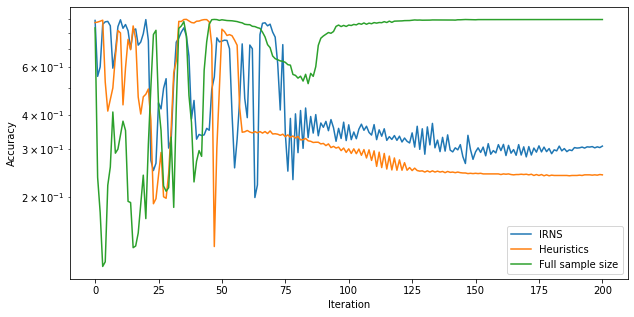

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(ACC_IRNS)
plt.plot(ACC_HEUR)
plt.plot(ACC_FSS)
plt.legend(["IRNS","Heuristics","Full sample size"], loc ="lower right")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.yscale("log")  
plt.show()

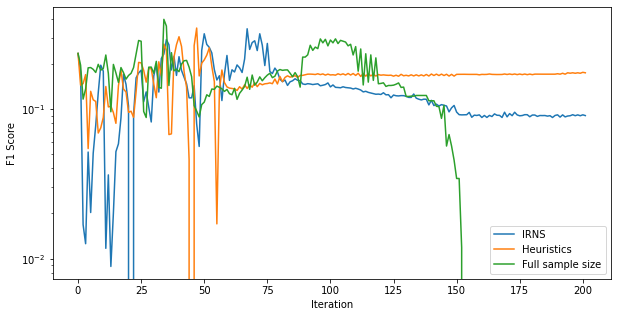

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(F1_IRNS)
plt.plot(F1_HEUR)
plt.plot(F1_FSS)
plt.legend(["IRNS","Heuristics","Full sample size"], loc ="lower right")
plt.xlabel("Iteration")
plt.ylabel("F1 Score")
plt.yscale("log")  
plt.show()

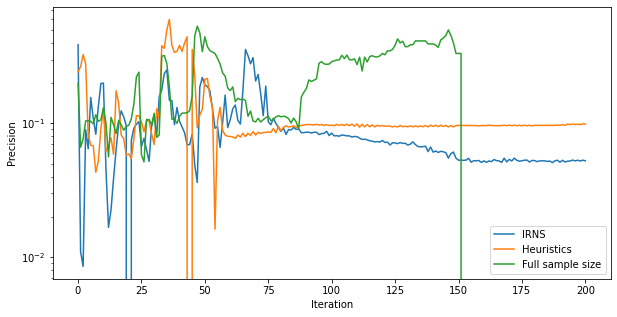

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(PREC_IRNS)
plt.plot(PREC_HEUR)
plt.plot(PREC_FSS)
plt.legend(["IRNS", "Heuristics","Full sample size"], loc ="lower right")
plt.xlabel("Iteration")
plt.ylabel("Precision")
plt.yscale("log")  
plt.show()

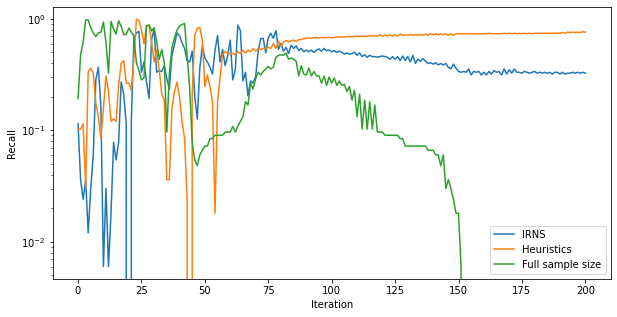

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(REC_IRNS)
plt.plot(REC_HEUR)
plt.plot(REC_FSS)
plt.legend(["IRNS", "Heuristics","Full sample size"], loc ="lower right")
plt.xlabel("Iteration")
plt.ylabel("Recall")
plt.yscale("log")  
plt.show()

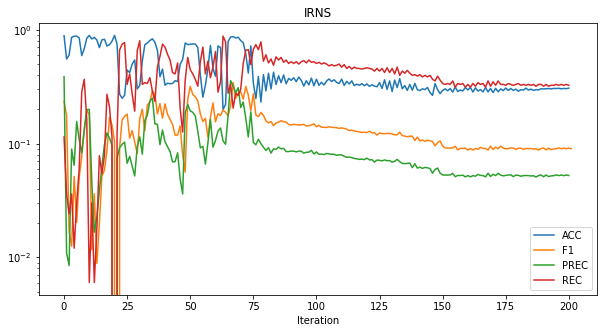

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(ACC_IRNS)
plt.plot(F1_IRNS)
plt.plot(PREC_IRNS)
plt.plot(REC_IRNS)
plt.legend(["ACC","F1","PREC","REC"], loc ="lower right")
plt.xlabel("Iteration")
plt.yscale("log")  
plt.title("IRNS")
plt.show()

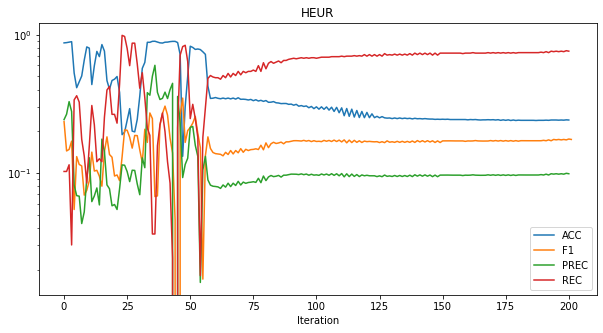

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(ACC_HEUR)
plt.plot(F1_HEUR)
plt.plot(PREC_HEUR)
plt.plot(REC_HEUR)
plt.legend(["ACC","F1","PREC","REC"], loc ="lower right")
plt.xlabel("Iteration")
plt.yscale("log")  
plt.title("HEUR")
plt.show()

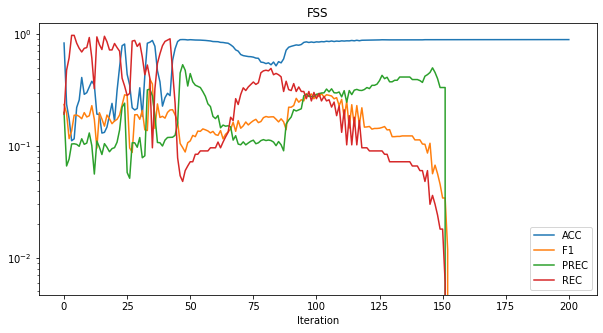

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(ACC_FSS)
plt.plot(F1_FSS)
plt.plot(PREC_FSS)
plt.plot(REC_FSS)
plt.legend(["ACC","F1","PREC","REC"], loc ="lower right")
plt.xlabel("Iteration")
plt.yscale("log")  
plt.title("FSS")
plt.show()

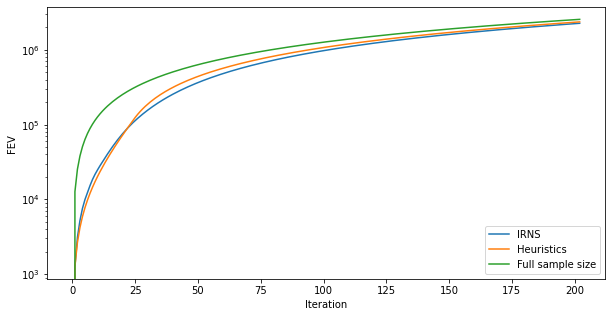

In [50]:
plt.figure(figsize=(10, 5))
plt.plot(MAX_FEV_IRNS)
plt.plot(MAX_FEV_HEUR)
plt.plot(MAX_FEV_FSS)
plt.legend(["IRNS", "Heuristics","Full sample size"], loc ="lower right")

plt.xlabel("Iteration")
plt.ylabel("FEV")
plt.yscale("log")  
plt.show()

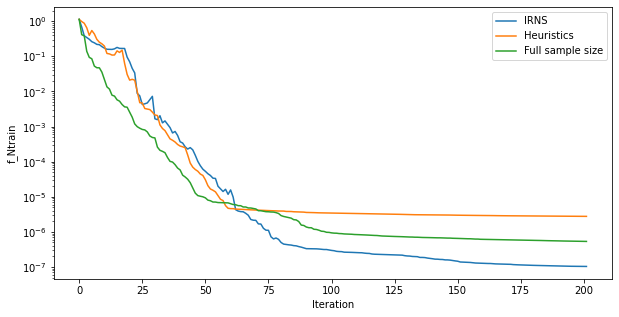

In [44]:
plt.figure(figsize=(10, 5))
plt.plot(f_Ntrain_IRNS)
plt.plot(f_Ntrain_HEUR)
plt.plot(f_Ntrain_FSS)
plt.legend(["IRNS", "Heuristics","Full sample size"], loc ="upper right")
plt.xlabel("Iteration")
plt.ylabel("f_Ntrain")
plt.yscale("log")  
plt.show()

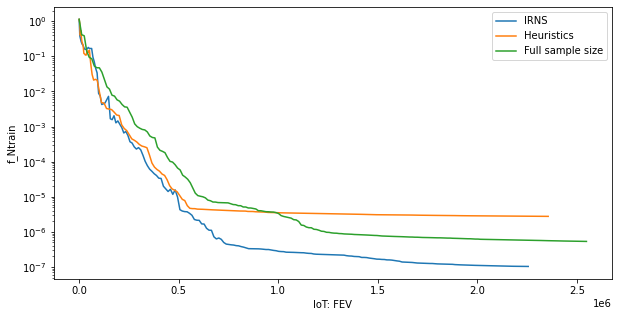

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(MAX_FEV_IRNS[:-1],f_Ntrain_IRNS)
plt.plot(MAX_FEV_HEUR[:-1],f_Ntrain_HEUR)
plt.plot(MAX_FEV_FSS[:-1],f_Ntrain_FSS)
plt.legend(["IRNS", "Heuristics","Full sample size"], loc ="upper right")
plt.xlabel("IoT: FEV")
plt.ylabel("f_Ntrain")
plt.yscale("log")  
plt.show()

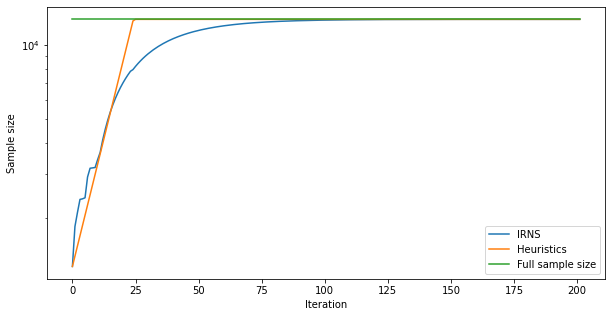

In [49]:
plt.figure(figsize=(10, 5))
plt.plot(N_IRNS)
plt.plot(N_HEUR)
plt.plot(N_FSS)
plt.legend(["IRNS", "Heuristics","Full sample size"], loc ="lower right")
plt.xlabel("Iteration")
plt.ylabel("Sample size")
plt.yscale("log")  
plt.show()